<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/dev/notebooks/exorim_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!git checkout dev

Cloning into 'ExoRIM'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (326/326), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 961 (delta 194), reused 203 (delta 83), pack-reused 635
Receiving objects: 100% (961/961), 19.47 MiB | 34.91 MiB/s, done.
Resolving deltas: 100% (585/585), done.
/content/ExoRIM
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [2]:
!pip install wandb
!python setup.py develop
!pip install celluloid

     |████████████████████████████████| 2.0MB 18.2MB/s 
     |████████████████████████████████| 163kB 56.0MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 133kB 51.3MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=9bd56cec270b734ddf516175561eef542acc12fe581acdf20e245a777345b39e
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=3be6de82c3b3392a219174e26239855ede41a8f98d0c6139f84bcf6c504f964c
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
running develop
running egg_info
creating ExoRIM.egg-info
writing ExoRIM.egg-info/PKG-INFO
writing dependency_links to ExoRIM.egg-info/dependency_l

In [5]:
from ExoRIM import RIM, MSE, PhysicalModel
from ExoRIM.loss import MAE, Loss
from preprocessing.simulate_data import create_and_save_data
from ExoRIM.simulated_data import CenteredBinaries 
from ExoRIM.definitions import dtype
from ExoRIM.utilities import create_dataset_from_generator, replay_dataset_from_generator
from argparse import ArgumentParser
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
import os
import wandb

import matplotlib.pyplot as plt
from glob import glob
from celluloid import Camera
import collections
import pickle
from IPython.display import HTML
# os.mkdir("logs")

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def create_datasets(meta_data, rim, dirname, batch_size=None, index_save_mod=1, format="txt"):
    images = tf.convert_to_tensor(create_and_save_data(dirname, meta_data, index_save_mod, format), dtype=dtype)
    noisy_data = rim.physical_model.forward(images) # TODO make this noisy forward
    X = tf.data.Dataset.from_tensor_slices(noisy_data)  # split along batch dimension
    Y = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf.data.Dataset.zip((X, Y))
    if batch_size is not None: # for train set
        dataset = dataset.batch(batch_size, drop_remainder=True)
        # dataset = dataset.enumerate(start=0)
        dataset = dataset.cache()  # accelerate the second and subsequent iterations over the dataset
        dataset = dataset.prefetch(AUTOTUNE)  # Batch is prefetched by CPU while training on the previous batch occurs
    else:
        # batch together all examples, for test set
        dataset = dataset.batch(images.shape[0], drop_remainder=True)
        dataset = dataset.cache()
    return dataset


In [83]:
parser = ArgumentParser()
parser.add_argument("--hyperparameters", type=str, default="hyperparameters128",
                    help="Name of the hyperparameter file (without the file extension)")
parser.add_argument("--tv", type=float, default=0., help="Total variation coefficient for the loss function")
parser.add_argument("-n", "--number_images", type=int, default=100)
parser.add_argument("-w", "--wavelength", type=float, default=0.5e-6)
parser.add_argument("--SNR", type=float, default=10, help="Signal to noise ratio")
parser.add_argument("-s", "--split", type=float, default=0.8)
parser.add_argument("-b", "--batch", type=int, default=10, help="Batch size")
parser.add_argument("-t", "--training_time", type=float, default=2, help="Time allowed for training in hours")
parser.add_argument("--holes", type=int, default=12, help="Number of holes in the mask")
parser.add_argument("--longest_baseline", type=float, default=6., help="Longest baseline (meters) in the mask, up to noise added")
parser.add_argument("--mask_variance", type=float, default=1., help="Variance of the noise added to rho coordinate of aperture (in meter)")
parser.add_argument("-m", "--min_delta", type=float, default=0, help="Tolerance for early stopping")
parser.add_argument("-p", "--patience", type=int, default=3, help="Patience for early stopping")
parser.add_argument("-c", "--checkpoint", type=int, default=5, help="Checkpoint to save model weights")
parser.add_argument("-e", "--max_epoch", type=int, default=10, help="Maximum number of epoch")
parser.add_argument("--index_save_mod", type=int, default=1, help="Image index to be saved")
parser.add_argument("--epoch_save_mod", type=int, default=1, help="Epoch at which to save images")
parser.add_argument("--noise_floor", type=float, default=1e-16, help="Intensity noise floor")
parser.add_argument("--format", type=str, default="png", help="Format with which to save image, either png or txt")
parser.add_argument("--fixed", action="store_true", help="Keeps the dataset fix for each epochs to monitor progress")
args = parser.parse_args("")

wandb.init(project="exorim", entity="adam-alexandre01123", sync_tensorboard=True, config=args)

date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
h_file = args.hyperparameters + ".json"
with open(h_file, "r") as f:
    hyperparameters = json.load(f)
try:
    name = hyperparameters["name"]
    id = date + "_" + name
except KeyError:
    id = date

print(f"id = {id}")
hyperparameters["batch"] = args.batch
hyperparameters["date"] = date
# metrics only support grey scale images
mae = MAE()

basedir = os.getcwd()  # assumes script is run from base directory
results_dir = os.path.join(basedir, "results", id)
os.mkdir(results_dir)
models_dir = os.path.join(basedir, "models", id)
os.mkdir(models_dir)
data_dir = os.path.join(basedir, "data", id)
os.mkdir(data_dir)
train_dir = os.path.join(data_dir, "train")
os.mkdir(train_dir)
test_dir = os.path.join(data_dir, "test")
os.mkdir(test_dir)

# another approach to save results using tensorboard and wandb
logdir = os.path.join(basedir, "logs", id)
os.mkdir(logdir)
os.mkdir(os.path.join(logdir, "train"))
os.mkdir(os.path.join(logdir, "test"))


mask = np.random.normal(0, args.longest_baseline/2, (args.holes, 2))
phys = PhysicalModel(
    pixels=hyperparameters["pixels"],
    mask_coordinates=mask,
    wavelength=args.wavelength,
    SNR=args.SNR,
    lam=1e8
)

rim = RIM(physical_model=phys, hyperparameters=hyperparameters, noise_floor=args.noise_floor)
train_meta = CenteredBinaries(total_items=int(args.split * args.number_images), pixels=hyperparameters["pixels"], width=1)
testmeta = CenteredBinaries(total_items=int((1 - args.split) * args.number_images), pixels=hyperparameters["pixels"], width=1)

train_dataset = create_datasets(train_meta, rim, train_dir, batch_size=args.batch, index_save_mod=args.index_save_mod, format="txt")
test_dataset = create_datasets(testmeta, rim, test_dir, batch_size=None, index_save_mod=1, format="txt")
cost_function = MSE()
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    **hyperparameters["learning rate"],
)
# CHEAT!
for (X, Y) in train_dataset:
    print("cheat activated")
    phys.prior = Y
    break


history = rim.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    max_time=args.training_time,
    cost_function=cost_function,
    min_delta=args.min_delta,
    patience=args.patience,
    metrics=None,#metrics,
    track="train_loss",
    # checkpoints=args.checkpoint,
    # output_dir=results_dir,
    # checkpoint_dir=models_dir,
    max_epochs=args.max_epoch,
    # logdir=logdir,
    output_save_mod={
        "index_mod": args.index_save_mod,
        "epoch_mod": args.epoch_save_mod,
        "step_mod": 1,
        "timestep_mod": 1
    }
)
for key, item in history.items():
    np.savetxt(os.path.join(results_dir, key + ".txt"), item)
with open(os.path.join(models_dir, "hyperparametres.json"), "w") as f:
    json.dump(rim.hyperparameters, f)

id = 21-03-04_23-32-18
66 distinct baselines found. Mask has 0 redundant baselines
There are 55 independant closure phases
cheat activated


InvalidArgumentError: ignored

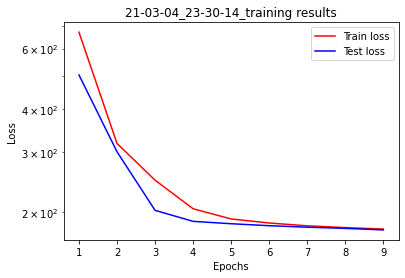

In [77]:
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

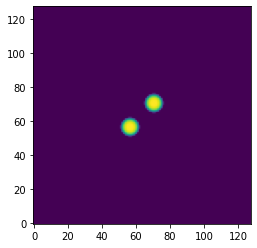

In [78]:
pixels = hyperparameters["pixels"]
x = np.arange(pixels) - pixels//2 + 0.5
xx, yy = np.meshgrid(x, x)
image = np.zeros((pixels, pixels))
image += np.exp(-0.5 * np.hypot(xx - 7, yy - 7)**4/16)
image += np.exp(-0.5 * np.hypot(xx + 7, yy + 7)**4/16)
image /= image.sum()
plt.imshow(np.log(image + 1e-16), origin="lower")

In [79]:
image = image[np.newaxis, ..., np.newaxis]
X = phys.forward(tf.constant(image, tf.float32))
out, grad = rim(X)

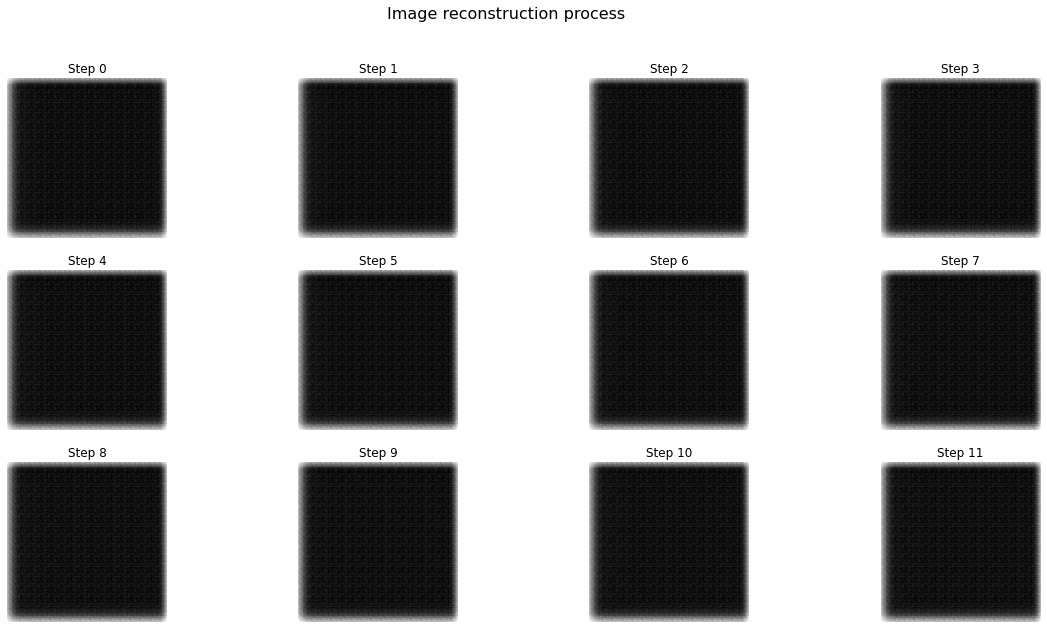

In [80]:
fig,axs = plt.subplots(3, 4, figsize=(20, 10))
k = 0
fig.suptitle("Image reconstruction process", fontsize=16)
for i in range(3):
  for j in range(4):
    axs[i, j].imshow(out[0, ..., 0, k].numpy(), cmap="gray", vmin=None, vmax=None, origin="lower")
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


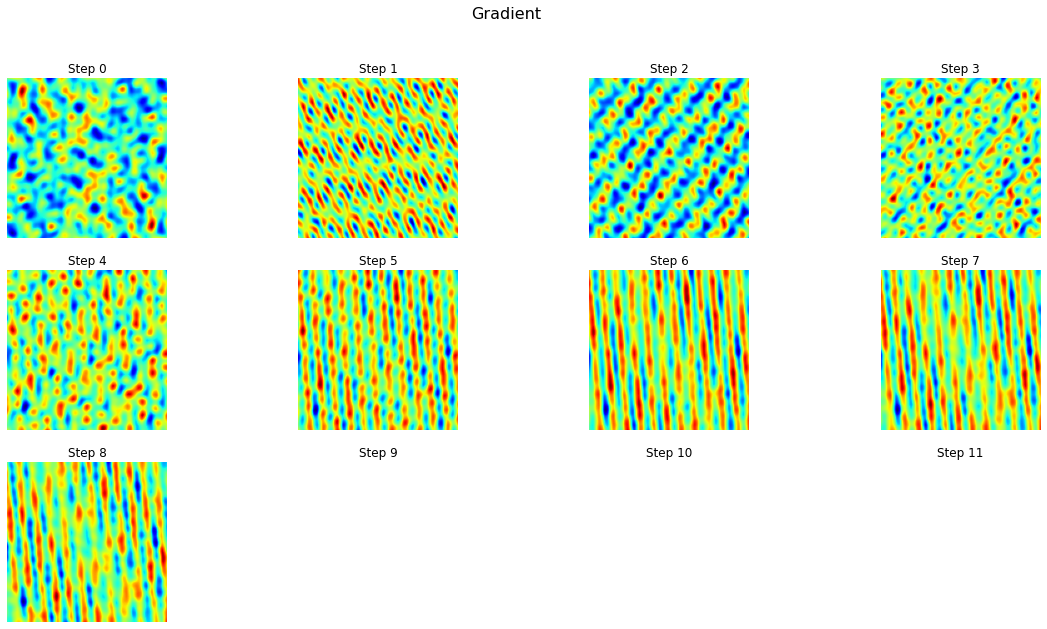

In [81]:
fig,axs = plt.subplots(3, 4, figsize=(20, 10))
k = 0
fig.suptitle("Gradient", fontsize=16)
for i in range(3):
  for j in range(4):
    axs[i, j].imshow(grad[0, ..., k].numpy(), cmap="jet", origin="lower")#, vmin=-1000, vmax=1000)
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

66 distinct baselines found. Mask has 0 redundant baselines
There are 55 independant closure phases


(-0.5, 127.5, 127.5, -0.5)

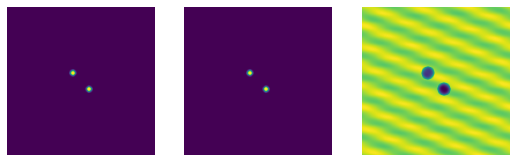

In [50]:
phys = PhysicalModel(
    pixels=hyperparameters["pixels"],
    mask_coordinates=mask,
    wavelength=args.wavelength,
    SNR=args.SNR,
    lam=1e6
)

prior = np.zeros((pixels, pixels))
pred = np.zeros((pixels, pixels))

# prior += np.exp(-0.5 * np.hypot(xx - 7, yy - 7)**4/16)
# prior += np.exp(-0.5 * np.hypot(xx + 7, yy + 7)**4/16)

prior /= image.sum()

pred += 1/prior.size
pred = tf.constant(pred.reshape([1, pixels, pixels, 1]), tf.float32)
phys.prior = tf.constant(prior.reshape([1, pixels, pixels, 1]), tf.float32)
X = phys.forward(image)

grad = phys.grad_log_likelihood(pred, X)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(image[0, ..., 0])
axs[0].axis("off")
axs[1].imshow(prior)
axs[1].axis("off")
axs[2].imshow(grad[0, ..., 0].numpy())
axs[2].axis("off")

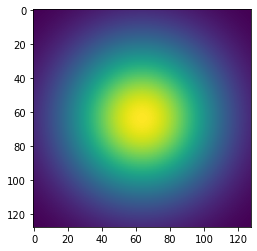

In [73]:
plt.imshow(phys.prior[0, ..., 0])